In [196]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import LogNorm
import os
import seaborn as sns
import pandas as pd
import json
import scipy
from scipy.misc import imread
import matplotlib.cbook as cbook
from matplotlib import gridspec
import math
%matplotlib inline

In [2]:
## Change this accoringly ##
DATA_ROOT = '/Users/jan/code/nip-deeprl-project/data'
############################

In [3]:
STATS_PREFIX = 'episode_stats.'
REPLAY_BUFFER_PREFIX ='replay_buffer.episode_'
MANIFEST_NAME = 'experiment.manifest.json'
NPZ_TMP_EXT = '_.gstmp'

In [342]:
def running_mean_multi(arr, win_len):
    mean_arr = np.empty_like(arr)
    for i in range(mean_arr.shape[1]):
        mean_arr[:,i] = np.mean(arr[:,i+1-win_len if i >= win_len else 0:i+1], axis=1)
    return mean_arr

def running_mean_run(arr, win_len):
    mean_arr = np.cumsum(arr)
    mean_arr[win_len:] = mean_arr[win_len:] - mean_arr[:-win_len]
    mean_arr[win_len:] /= win_len
    mean_arr[:win_len] = [mean_arr[i] / float(i+1) for i in range(win_len)]
    return mean_arr

def test_running_mean_multi():
    test = np.arange(9, dtype=float).reshape(3,3)
    mean_test = running_mean_multi(test, 2)
    assert (mean_test == np.array([0., 0.5, 1.5, 3., 3.5, 4.5, 6., 6.5, 7.5]).reshape(3,3)).all(), \
        "running_mean_multi(..) is bugged"
        
def test_running_mean_run():
    test = np.arange(9, dtype=float)
    mean_test = running_mean_run(test, 3)
    assert (mean_test == np.array([0., 0.5, 1., 2., 3., 4., 5., 6., 7.])).all(), \
        "running_mean_run(..) is bugged"
test_running_mean_multi()
test_running_mean_run()

def read_manifest(directory):
    fname = [f for f in next(os.walk(directory))[2] if f == MANIFEST_NAME][0]
    with open(os.path.join(directory, fname)) as f:
        return json.load(f)
    
def read_episode_stats_config(directory, num_run=None):
    run_dirs = next(os.walk(directory))[1]
    
    ep_rews, ep_lens, ep_times = [], [], []
    for i, run_dir in enumerate(run_dirs):
        if num_run is not None and i == num_run:
            break
        ep_stats = _read_episode_stats_run(os.path.join(directory, run_dir))
        ep_rews.append(ep_stats[0])
        ep_lens.append(ep_stats[1])
        ep_times.append(ep_stats[2])
        
    stats_dict = {}
    stats_dict['rews'] = np.array(ep_rews)
    stats_dict['lens'] = np.array(ep_lens)
    stats_dict['times'] = np.array(ep_times)
    return stats_dict

def read_replay_buffer_config(directory, num_run=None):
    # CAUTION, THIS TAKES AGES!
    run_dirs = next(os.walk(directory))[1]
    
    obs, acts, rews, dones = [], [], [], []
    for i, run_dir in enumerate(run_dirs):
        if num_run is not None and i == num_run:
            break
        rpb = _read_replay_buffer_run(os.path.join(directory, run_dir))
        obs.append(rpb[0])
        dones.append(rpb[1])
        rews.append(rpb[2])
        acts.append(rpb[3])
        
    buffer_dict = {}
    buffer_dict['obs'] = np.array(obs)
    buffer_dict['rews'] = np.array(rews)
    buffer_dict['acts'] = np.array(acts)
    buffer_dict['dones'] = np.array(dones)
    return buffer_dict
def _read_episode_stats_run(directory):
    files = next(os.walk(directory))[2]
    ep_rews, ep_lens, ep_times = [], [], []
    for fname in (f for f in files if f.startswith(STATS_PREFIX)):
        if fname.endswith(NPZ_TMP_EXT):
            continue
        with np.load(os.path.join(directory , fname)) as data:
            ep_rews.extend(data['episode_rewards'])
            ep_lens.extend(data['episode_lengths'])
            ep_times.extend(data['episode_end_times'])
    return np.array(ep_rews), np.array(ep_lens), np.array(ep_times)

def _read_replay_buffer_run(directory):
    files = next(os.walk(directory))[2]
    obs, dones, rews, acts = [], [], [], []
    for fname in (f for f in files if f.startswith(REPLAY_BUFFER_PREFIX)):
        if fname.endswith(NPZ_TMP_EXT):
            continue
        with np.load(os.path.join(directory ,fname)) as data:
            obs.extend(data['observations'])
            dones.extend(data['dones'])
            rews.extend(data['rewards'])
            acts.extend(data['actions'])
    return np.array(obs), np.array(acts), np.array(rews), np.array(dones)

def obs_to_dict(obses):
    obs_dict = {}
    obs_dict['pos_x'] = obses[:,0]
    obs_dict['pos_y'] = obses[:,1]
    obs_dict['vel_x'] = obses[:,2]
    obs_dict['vel_y'] = obses[:,3]
    obs_dict['angle'] = obses[:,4]
    obs_dict['vel_angle'] = obses[:,5]
    obs_dict['l0_touchdown'] = obses[:,6]
    obs_dict['l1_touchdown'] = obses[:,7]
    return obs_dict

def find_avail_setups():
    '''Return dict with key=env, value=list(config1, ..., confign)'''
    setups = {}
    for env in [sd for sd in next(os.walk(DATA_ROOT))[1] if not sd.startswith('.')]:
        setups[env] = [sd for sd in next(os.walk(os.path.join(DATA_ROOT, env)))[1]]
    return setups

def _plot_std_band(*args, central_data=None, ci=None, data=None, **kwargs):
    # Hack seaborne timeseries to show std instead of conf. interval
    std = data.std(axis=0)
    ci = np.asarray((central_data - std, central_data + std))
    kwargs.update({"central_data": central_data, "ci": ci, "data": data})
    sns.timeseries._plot_ci_band(*args, **kwargs)

def plot_data(data, ax, color=None):
    sns.set_context(font_scale=15)
    sns.timeseries._plot_std_band = _plot_std_band
    return sns.tsplot(data, err_style="std_band", n_boot=0, ax=ax, color=color)
    
def visualize_stats(config_stats, manifest): 
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    ep_rws = config_stats['rews'] / 200. # normalized w.r.t to expected final reward of a solved agent
    ep_lns = config_stats['lens'] / 1000. # normalized w.r.t to max episode length
    ep_tms = config_stats['times'] # no normilzation
    smoothed_ep_rws = running_mean_multi(ep_rws, 10)
    smoothed_ep_lns = running_mean_multi(ep_lns, 10)
    smoothed_ep_tms = running_mean_multi(ep_tms, 10)
        
    sec_label = 'Arch:{} - buffer-size:{} - minibatch-size:{} - num_steps:{} - schedule_steps:{}'\
        .format(manifest['args']['arch'],
                manifest['args']['replay_buffer_size'],
                manifest['args']['batch_size'],
                manifest['args']['num_steps'],
                manifest['args']['schedule_timesteps'])
    # episode in which we hit num_steps
    ep_num_steps = np.argmin(abs(np.cumsum(config_stats['lens']) - manifest['args']['num_steps']))
    # episode in which we stop annealing
    ep_schedule_steps = np.argmin(abs(np.cumsum(config_stats['lens']) - manifest['args']['schedule_timesteps']))
    # first time replay buffer is completely filled
    rpb_full = np.argmin(abs(np.cumsum(config_stats['lens']) - manifest['args']['replay_buffer_size']))

    plot_data(ep_rws, ax, color=sns.color_palette("Blues", 20)[14])
    rws_plot = mpatches.Patch(color=sns.color_palette("Blues", 20)[14])

    plot_data(smoothed_ep_rws, ax, color=sns.color_palette("Blues", 20)[19])
    smoothed_rws_plot = mpatches.Patch(color=sns.color_palette("Blues", 20)[19])

    plot_data(smoothed_ep_lns, ax, color=sns.color_palette("Reds", 20)[14])
    lns_plot = mpatches.Patch(color=sns.color_palette("Reds", 20)[14])

    num_steps_line = ax.axvline(ep_num_steps, color='k', linestyle='--', linewidth=1)
    schedule_steps_line = ax.axvline(ep_schedule_steps, color='purple', linestyle='--', linewidth=1)
    
    rpb_full_lines = [ax.axvline(rpb_full * c, color='orange', linestyle='--', linewidth=1) for c in range(1, 10)]
    target_rew = ax.axhline(1., color='green', linestyle='-', linewidth=2)
    ax.set(xlabel='Episodes', ylabel='Normalized Total Reward / Episode Length')
    ax.set(title='{}\n{}'.format(config, sec_label))
    ax.legend([lns_plot, rws_plot, smoothed_rws_plot, num_steps_line, schedule_steps_line, rpb_full_lines[0], target_rew],
              ['Average Episode Length + σ', 'Total Reward + σ' , 'Smoothed Total Reward + σ', 'Episode reaching num_steps', 'Episode reaching minimum ε', 'Replay Buffer completely (re)filled', 'Target Reward'],
              fontsize='x-large', frameon=True, fancybox=True, shadow=True, facecolor='white')
    ax.set_ylim([-1.5, 1.5])
        
def visualize_pos_distrib(data, bg_img, ep_lens, step_size):
    plt.clf()
    count = math.ceil(ep_lens.shape[1] / step_size) 
    nrow = math.ceil(count/2)
    ncol = 2 if count > 1 else 1

    fig = plt.figure(figsize=(20, 5*nrow)) 
    gs = gridspec.GridSpec(nrow, ncol, width_ratios=[1, 1],
                           wspace=0.2, hspace=0.2, top=0.9, bottom=0.05, left=0.17, right=0.845) 
    
    
    acc_ep_lens = np.cumsum(ep_lens, axis=1)
    acc_ep_lens[:,0] = 0
        
    for i in range(count):
        ax = plt.subplot(gs[i//2, i%2])
        ax.imshow(img, zorder=1, extent=[-1., 1., -0.35, 1.], alpha=0.75)
        start_ep = i*step_size
        stop_ep = (i+1)*step_size if (i+1)*step_size < acc_ep_lens.shape[1] else acc_ep_lens.shape[1]-1
        
        starts = [run_lens[start_ep] for run_lens in acc_ep_lens] 
        stops = [run_lens[stop_ep] for run_lens in acc_ep_lens]

        d = np.hstack(data[r][:,starts[r]:stops[r]] for r in range(len(data)))
        heatmap = ax.hexbin(d[0,:], d[1,:],
                                 gridsize=60, cmap=cm.jet, bins=None, 
                                 norm=LogNorm(), alpha=1, zorder=0)

        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title('Episodes {} - {}'.format(start_ep, stop_ep), fontsize=14)
        ax.axis([-.93, .93, -0.2, 1.])
        ax.grid()
        
    cbar_ax = fig.add_axes([0.85, 0.05, 0.01, 0.85])
    cbar = fig.colorbar(heatmap, cax=cbar_ax)
    nticks = len(cbar.ax.get_yticks())
    custom_ticklabels = [''] * nticks
    custom_ticklabels[0] = 'low'
    custom_ticklabels[nticks // 2] = 'medium'
    custom_ticklabels[-1] = 'high'
    cbar.ax.set_yticklabels(custom_ticklabels, fontsize=14)

    cbar.set_label('rel. ferq of LL occuring at pos', fontsize=14)
    plt.suptitle('Relative Frequency of LL being at particular location', fontsize=18)
    plt.show()
    
def visualize_config(config_dir):
    print('Reading statistics...')
    config_stats = read_episode_stats_config(config_dir)
    manifest = read_manifest(config_dir)
    print('Visualizing statstics...')
    visualize_stats(config_stats, manifest)
    print('Reading replay buffer... (this may take a VERY long time)')
    buffer = read_replay_buffer_config(config_path)
    print('Visualizing location distribution... (this may take a while)')
    img = imread('ll_bg.jpg')
    visualize_pos_distrib([d[:,:2].T for d in buffer['obs']], 
                          bg_img=img, 
                          ep_lens=config_stats['lens'],
                          step_size=math.ceil(config_stats['lens'].shape[1] / 8.)) # 1/8 of max episodes

# Data Visualization

## LL_basic

Reading statistics...
Visualizing statstics...
Reading replay buffer... (this may take a VERY long time)
Visualizing location distribution... (this may take a while)


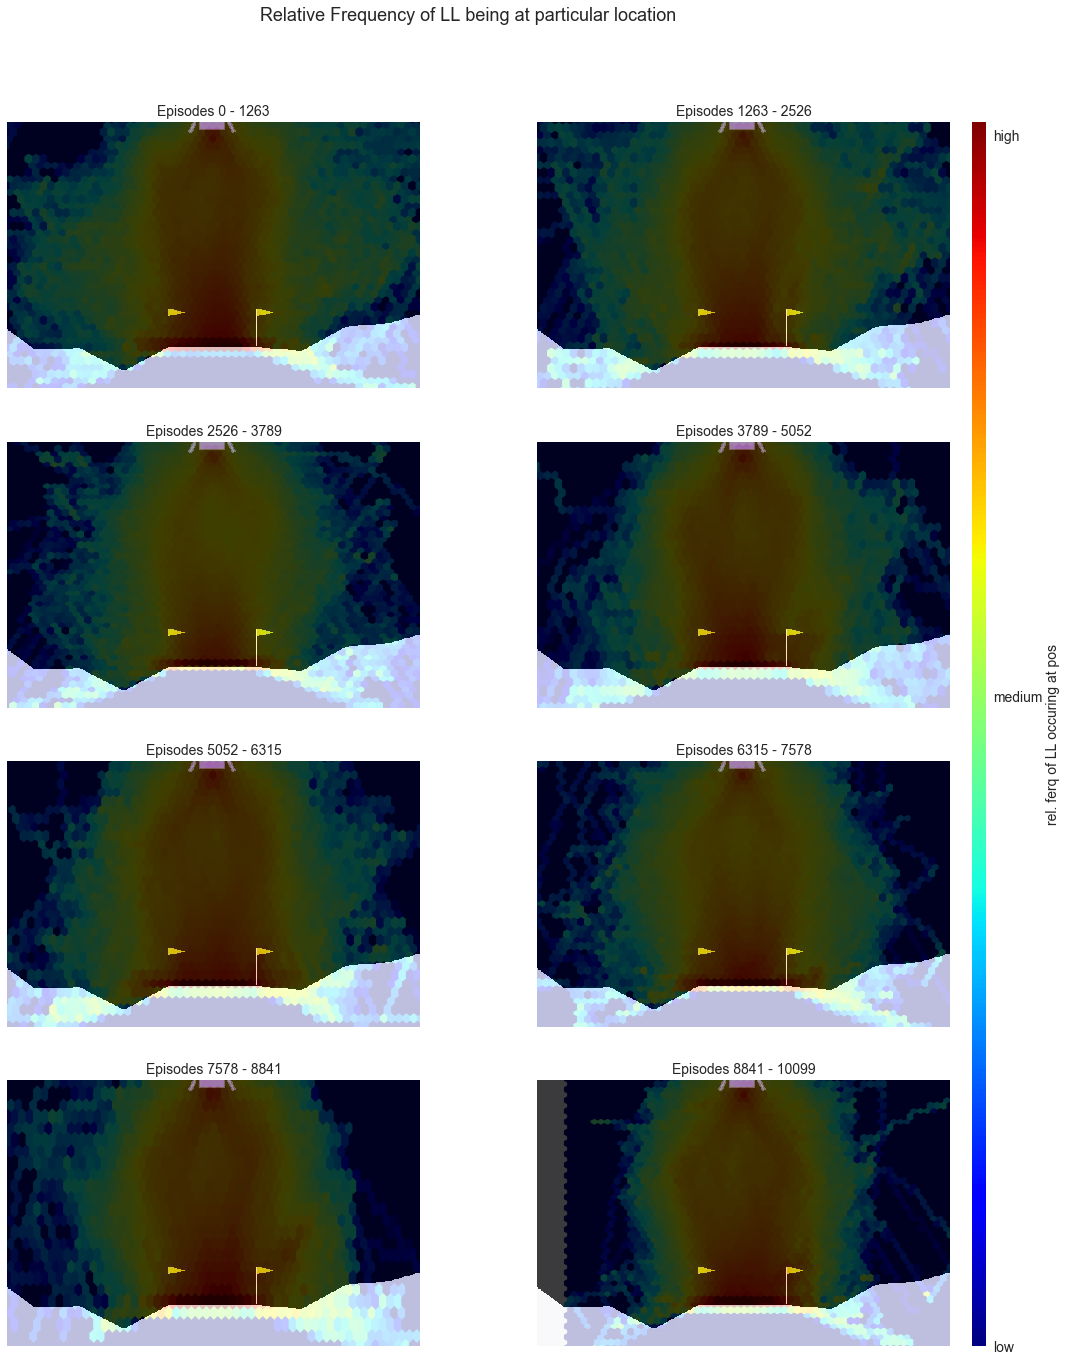

In [343]:
env = 'LunarLander-v2'
config_path = os.path.join(DATA_ROOT, env, setups[env][0])
visualize_config(config_path)

## LL_e500_rpb500

Reading statistics...
Visualizing statstics...
Reading replay buffer... (this may take a VERY long time)
Visualizing location distribution... (this may take a while)


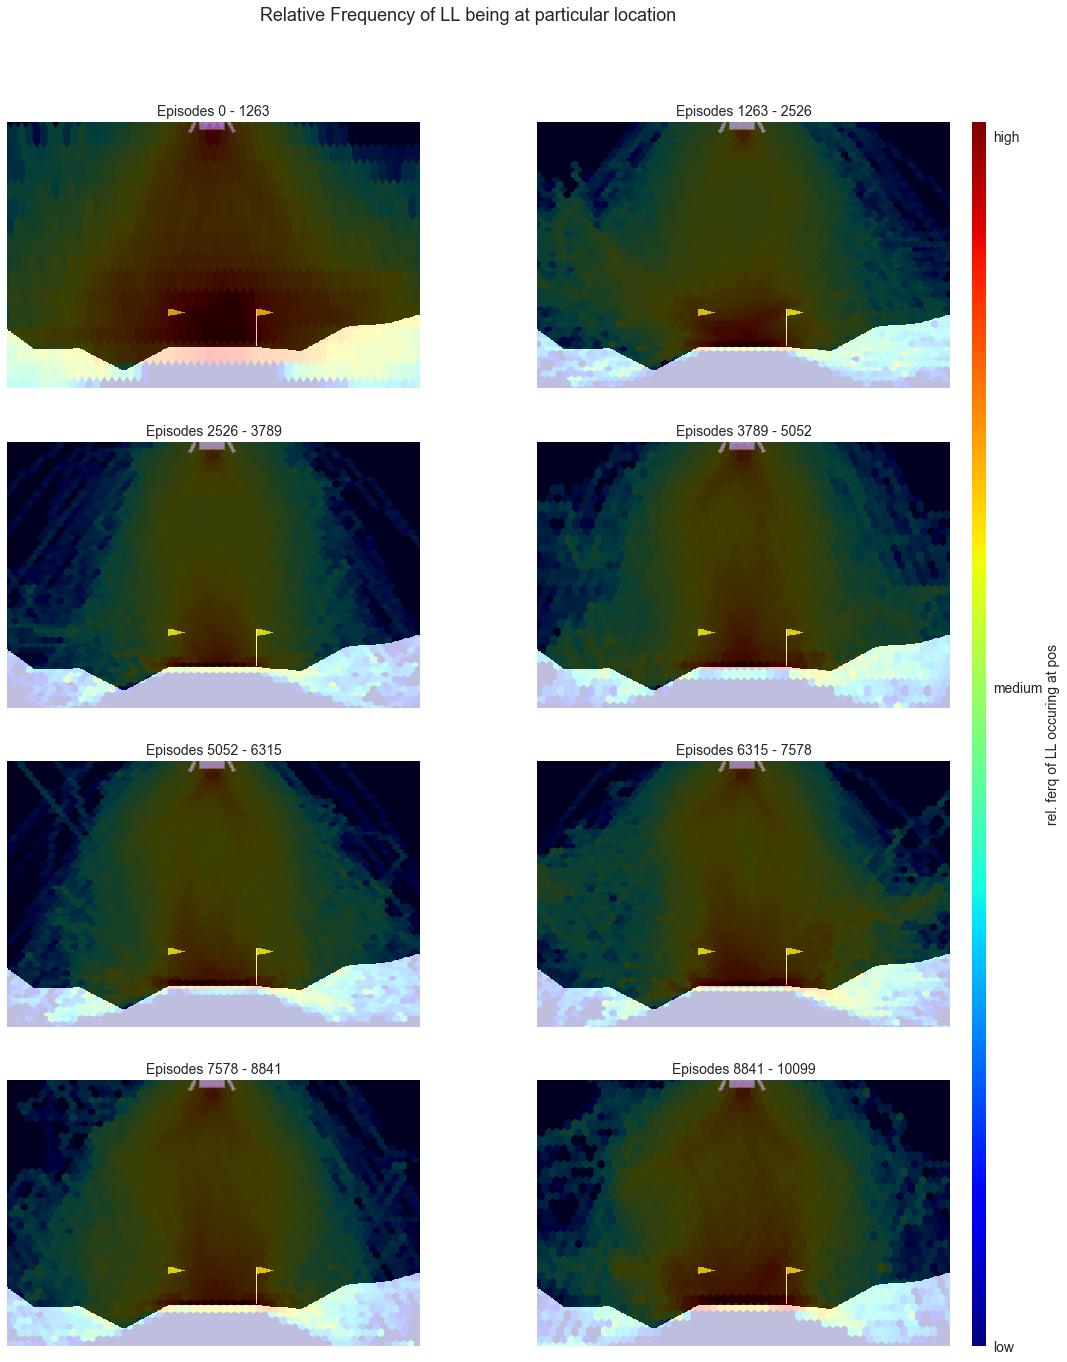

In [344]:
env = 'LunarLander-v2'
config_path = os.path.join(DATA_ROOT, env, setups[env][2])
visualize_config(config_path)

## LL_gc5

Reading statistics...
Visualizing statstics...
Reading replay buffer... (this may take a VERY long time)
Visualizing location distribution... (this may take a while)


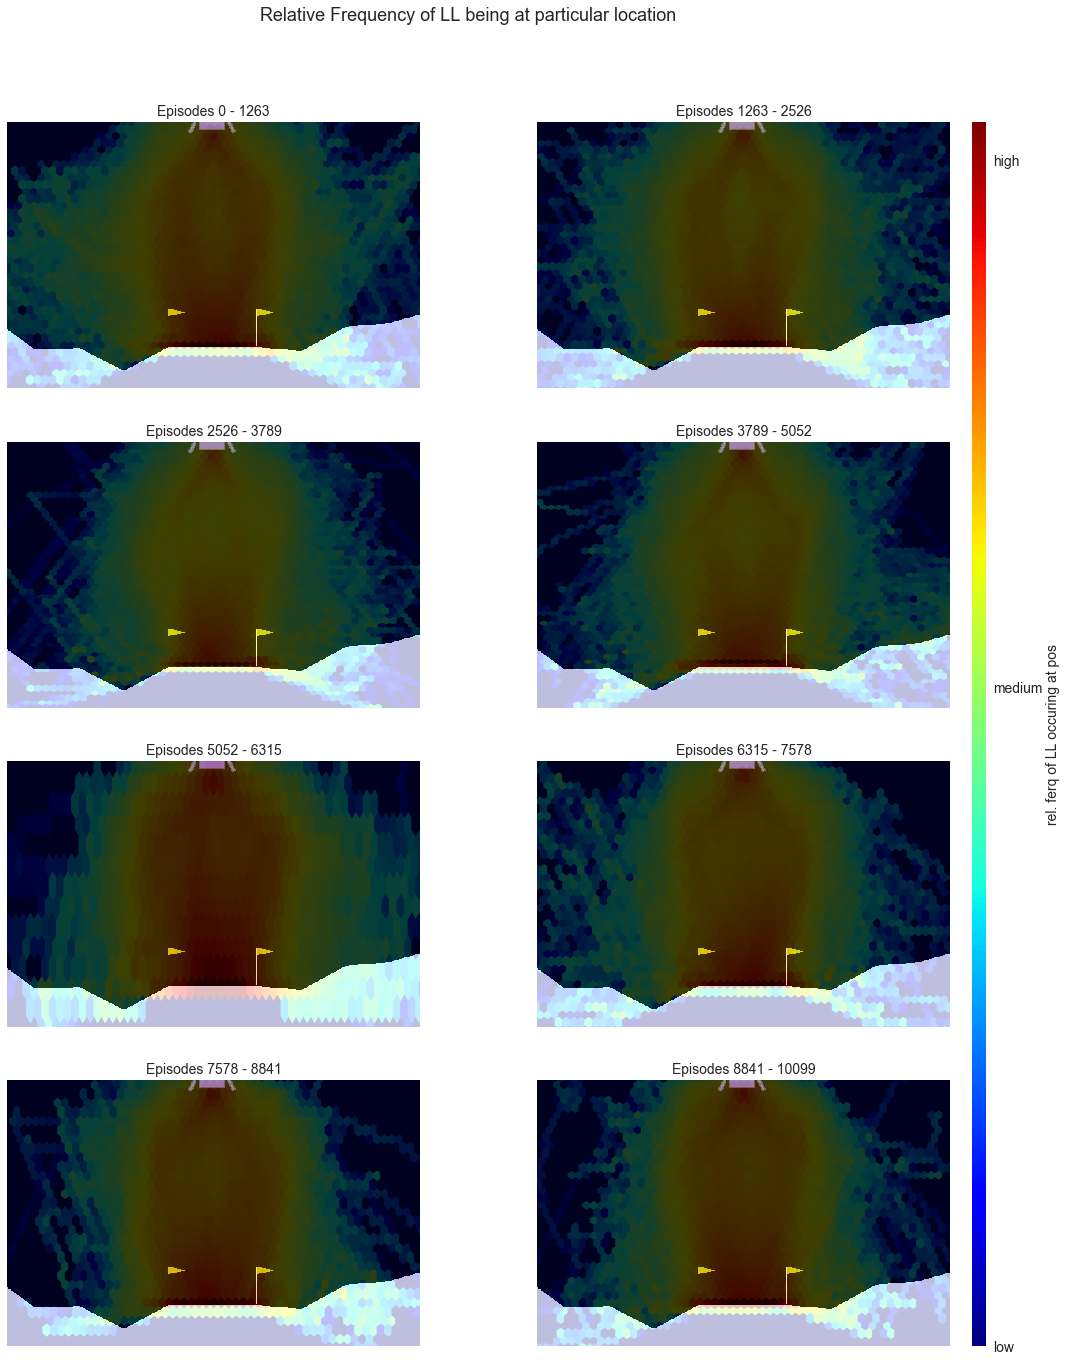

In [345]:
env = 'LunarLander-v2'
config_path = os.path.join(DATA_ROOT, env, setups[env][4])
visualize_config(config_path)

## LL_prio1

Reading statistics...
Visualizing statstics...
Reading replay buffer... (this may take a VERY long time)
Visualizing location distribution... (this may take a while)


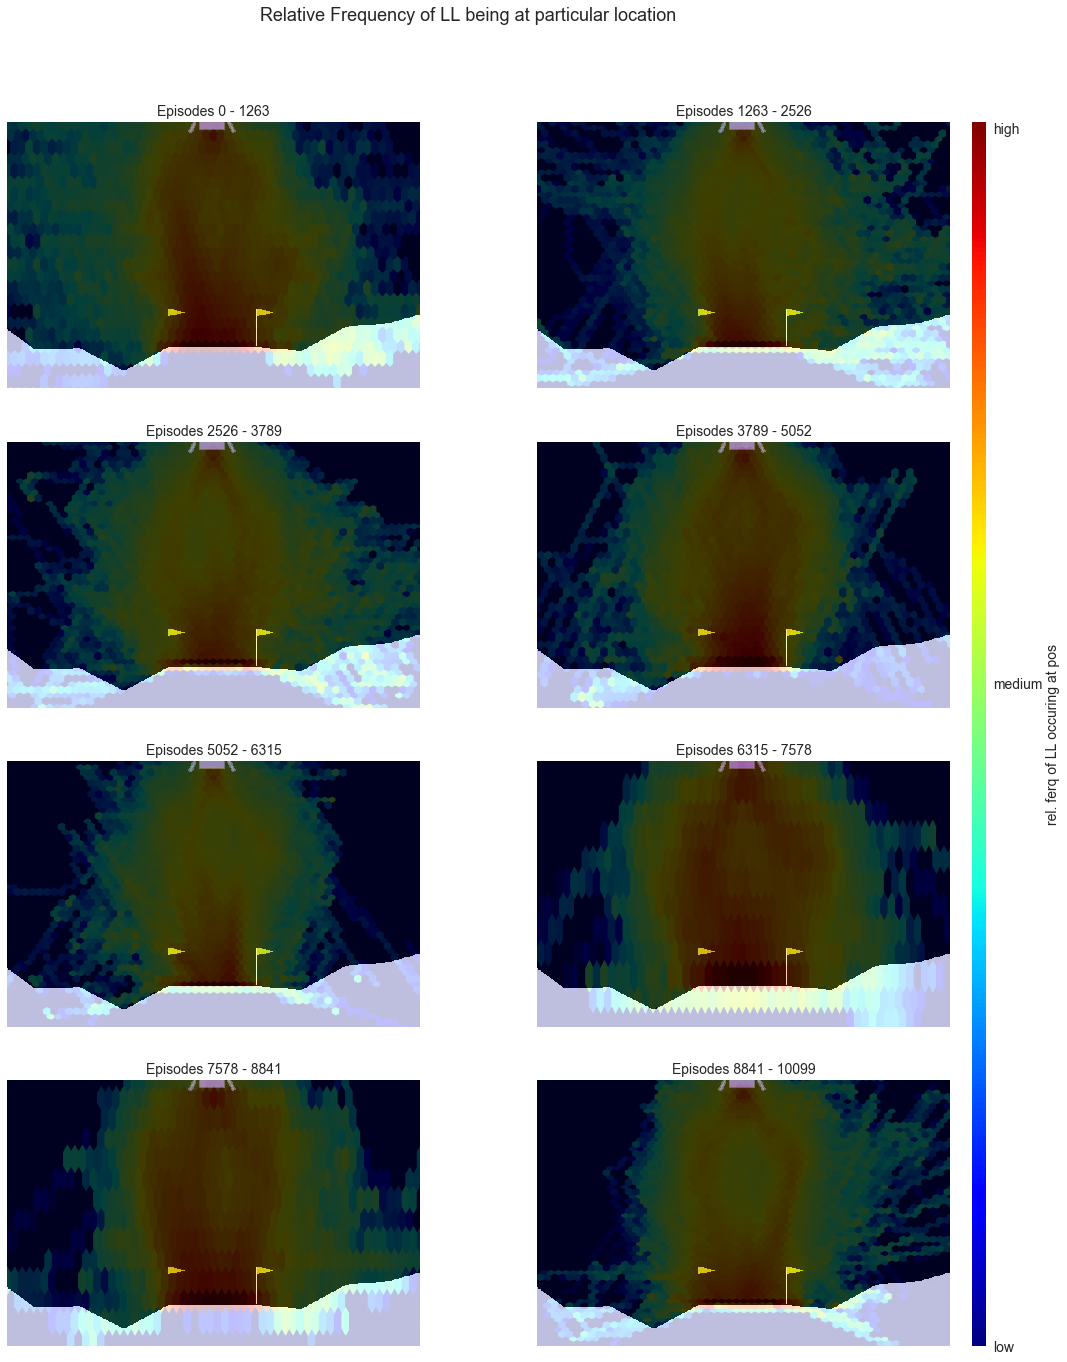

In [346]:
env = 'LunarLander-v2'
config_path = os.path.join(DATA_ROOT, env, setups[env][7])
visualize_config(config_path)